In [1]:
import random
import scipy
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import torch
import albumentations as A

%run ../metric_dissimilarity.py

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/home/lucas/.miniconda/envs/torch/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Read training data
train_data = scipy.io.loadmat("data/train_32x32.mat")
X_train, Y_train = train_data["X"], train_data["y"].ravel()

# Read test data
test_data = scipy.io.loadmat("data/test_32x32.mat")
X_test, Y_test = test_data["X"], test_data["y"].ravel()

# Transpose
X_train = X_train.transpose(3, 0, 1, 2)
X_test = X_test.transpose(3, 0, 1, 2)

lbl_encoder = sklearn.preprocessing.LabelEncoder().fit(Y_train)
Y_train = lbl_encoder.transform(Y_train)
Y_test = lbl_encoder.transform(Y_test)

In [3]:
np.random.seed(seed)
open_set = {}
size = round(len(np.unique(Y_train)) * (4 / 10))
for kfold in range(5):
  open_set[kfold] = np.random.choice(np.unique(Y_train), size = size, replace = False)

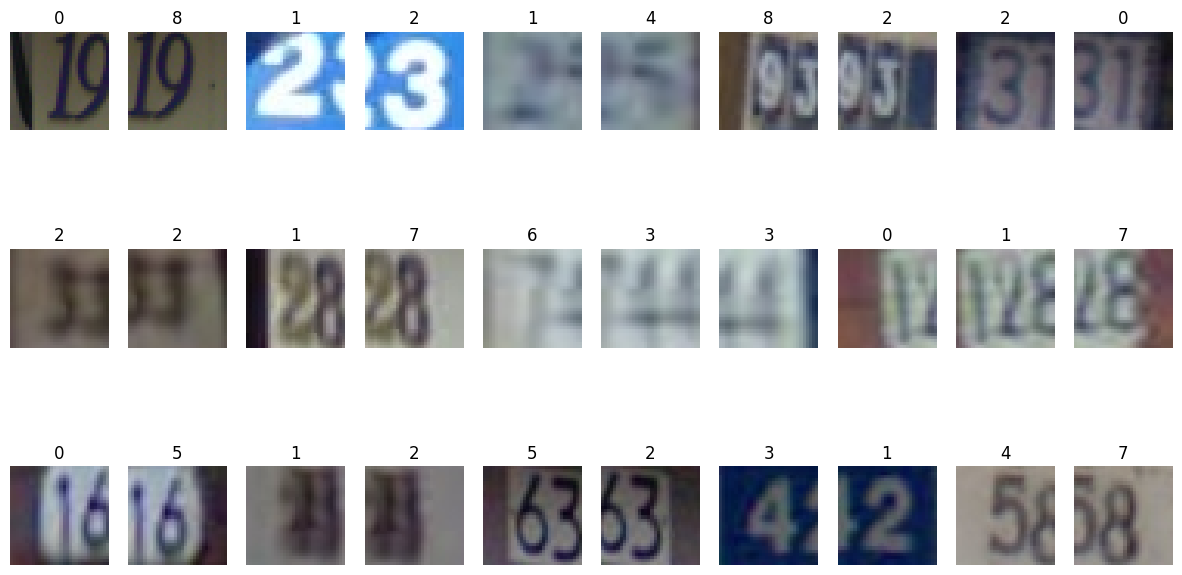

In [4]:
# Visualize some images and their corresponding labels.
plt.figure(figsize = (15, 8))
for i in range(30):
  ax = plt.subplot(3, 10, i + 1)
  plt.imshow(X_train[i] / 255.)
  plt.title(Y_train[i])
  plt.axis("off")

In [5]:
# Model training
models = {}

augments = A.Compose([
  A.RandomCrop(28, 28),
  A.Rotate(30),
  A.GaussianBlur(),
  A.RandomBrightnessContrast(),
  A.pytorch.ToTensorV2()
])

for kfold in range(5):

  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  X_train_known = X_train[train_known_indices]
  Y_train_known = Y_train[train_known_indices]

  models[kfold] = train(X_train_known, Y_train_known, 
                        model_type="triplet", backbone="VGG32", pretrained=False, augments=augments,
                        model_file=f"models/triplet-{kfold}.pth", top_layers=False,
                        clf_warmup=True,
                        embeddingsize=128, patch_size=(28,28),
                        batch=128, lr=0.01, iterations=250000)

Model file: models/triplet-0.pth
Loading pre-trained model...
Model is ready for evaluation.
Model file: models/triplet-1.pth
Loading pre-trained model...
Model is ready for evaluation.
Model file: models/triplet-2.pth
Loading pre-trained model...
Model is ready for evaluation.
Model file: models/triplet-3.pth
Loading pre-trained model...
Model is ready for evaluation.
Model file: models/triplet-4.pth
Training a new model...
Cross-entropy Warmup Phase
Warmup backbone
Epoch 1, Loss: 1.7627
Epoch 2, Loss: 1.7574
Epoch 3, Loss: 1.7531
Epoch 4, Loss: 1.7362
Epoch 5, Loss: 1.6819
Epoch 6, Loss: 1.5782
Epoch 7, Loss: 1.3301
Epoch 8, Loss: 1.0206
Epoch 9, Loss: 0.8266
Epoch 10, Loss: 0.6934
Epoch 11, Loss: 0.6141
Epoch 12, Loss: 0.5592
Epoch 13, Loss: 0.5177
Epoch 14, Loss: 0.4865
Epoch 15, Loss: 0.4608
Epoch 16, Loss: 0.4344
Epoch 17, Loss: 0.4153
Epoch 18, Loss: 0.3993
Epoch 19, Loss: 0.3836
Epoch 20, Loss: 0.3761
Epoch 21, Loss: 0.3598
Epoch 22, Loss: 0.3526
Epoch 23, Loss: 0.3420
Epoch 24

In [6]:
# Embedding generation
train_embeddings = {}
test_embeddings = {}

for kfold in range(5):

  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  X_train_known = X_train[train_known_indices]
  
  train_embeddings[kfold] = generate_embedding(models[kfold], X_train_known, patch_size=(28, 28), cache=f"cache/triplet/train-embedding-f{kfold}.pkl")
  test_embeddings[kfold] = generate_embedding(models[kfold], X_test, patch_size=(28, 28), cache=f"cache/triplet/test-embedding-f{kfold}.pkl")

In [ ]:
# Prototype generation
X_prot = {}
Y_prot = {}

for kfold in range(5):
  
  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  Y_train_known = Y_train[train_known_indices]
  
  X_prot[kfold], Y_prot[kfold] = compute_prototypes(train_embeddings[kfold], Y_train_known, 
                                                            n_prototypes=5, method="kmeans++", cache=f"cache/triplet/prototypes-f{kfold}.pkl")

In [8]:
# Contrastive dissimilarity space representation

acc_overall = []
msp_overall = []
mds_overall = []

for kfold in range(5):

  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  test_known_indices = ~np.isin(Y_test, open_set[kfold])
  Y_train_known = Y_train[train_known_indices]

  X_train_space = space_representation(models[kfold], train_embeddings[kfold], X_prot[kfold], cache=f"cache/triplet/space-train-f{kfold}.pkl")
  X_test_space = space_representation(models[kfold], test_embeddings[kfold], X_prot[kfold], cache=f"cache/triplet/space-test-f{kfold}.pkl")
  
  np.random.seed(42)

  # Train a regular classifier
  clf = sklearn.linear_model.LogisticRegression(max_iter=5000)
  clf.fit(X_train_space, Y_train_known)

  # Predict
  preds = clf.predict(X_test_space)
  probs = clf.predict_proba(X_test_space)

  # Closed-set accuracy
  closed_acc = closed_accuracy(preds, Y_test, test_known_indices)

  # Open-set scores
  msp = compute_msp(probs)
  mds = compute_mds(X_train_space, X_test_space, inverted=True)

  # AUROC
  msp_auroc = open_auroc(-msp, test_known_indices, ~test_known_indices)
  mds_auroc = open_auroc(mds, test_known_indices, ~test_known_indices)

  acc_overall.append(closed_acc)
  msp_overall.append(msp_auroc)
  mds_overall.append(mds_auroc)

# Print the overall results
pct = lambda x: f"{x*100:.1f}%"
fmt = lambda x: f"{x*100:.1f}"

print("\nOverall Results:")
print(f"{'':<8}{'Closed':>10}{'MSP AUROC':>12}{'MDS AUROC':>12}")
for kfold in range(5):
  print(f"{kfold:<8}{pct(acc_overall[kfold]):>10}{fmt(msp_overall[kfold]):>12}{fmt(mds_overall[kfold]):>12}")

  # CSV
  print(f"SVHN,All,Fold {kfold},VGG32,TDS,,Acck,,{acc_overall[kfold]}")
  print(f"SVHN,All,Fold {kfold},VGG32,TDS,MSP,AUROC,,{msp_overall[kfold]}")
  print(f"SVHN,All,Fold {kfold},VGG32,TDS,MDS,AUROC,,{mds_overall[kfold]}")

print(f"{'Mean':<13}{pct(np.mean(acc_overall)):<13}{fmt(np.mean(msp_overall)):<12}{fmt(np.mean(mds_overall)):<10}")
print(f"{'SD':<13}{pct(np.std(acc_overall)):<13}{fmt(np.std(msp_overall)):<12}{fmt(np.std(mds_overall)):<10}")


Overall Results:
            Closed   MSP AUROC   MDS AUROC
0            97.0%        92.4        72.8
SVHN,All,Fold 0,VGG32,TDS,,Acck,,0.9697377700839905
SVHN,All,Fold 0,VGG32,TDS,MSP,AUROC,,0.9236980229664036
SVHN,All,Fold 0,VGG32,TDS,MDS,AUROC,,0.7276076060355738
1            95.9%        89.9        82.4
SVHN,All,Fold 1,VGG32,TDS,,Acck,,0.9594861031609744
SVHN,All,Fold 1,VGG32,TDS,MSP,AUROC,,0.8993040075962989
SVHN,All,Fold 1,VGG32,TDS,MDS,AUROC,,0.8242268276472111
2            96.2%        90.6        82.8
SVHN,All,Fold 2,VGG32,TDS,,Acck,,0.9623681977942068
SVHN,All,Fold 2,VGG32,TDS,MSP,AUROC,,0.9057152791298916
SVHN,All,Fold 2,VGG32,TDS,MDS,AUROC,,0.8278172616171807
3            96.6%        91.9        95.3
SVHN,All,Fold 3,VGG32,TDS,,Acck,,0.9663244353182752
SVHN,All,Fold 3,VGG32,TDS,MSP,AUROC,,0.9186802957748395
SVHN,All,Fold 3,VGG32,TDS,MDS,AUROC,,0.9527436308950289
4            97.7%        93.5        79.2
SVHN,All,Fold 4,VGG32,TDS,,Acck,,0.9769441436851156
SVHN,All,Fold 4,

In [9]:
# Contrastive dissimilarity space representation

acc_overall = []
msp_overall = []
mds_overall = []

for kfold in range(5):

  train_known_indices = ~np.isin(Y_train, open_set[kfold])
  test_known_indices = ~np.isin(Y_test, open_set[kfold])

  X_train_known = X_train[train_known_indices]
  Y_train_known = Y_train[train_known_indices]

  X_train_vector, Y_train_vector = vector_representation(models[kfold], X_train_known, Y_train_known,
                                                         X_prot[kfold], Y_prot[kfold], patch_size=(28, 28), variations=5,
                                                         cache=f"cache/triplet/vector-train-f{kfold}.pkl")
  X_test_vector, _ = vector_representation(models[kfold], X_test, Y_test,
                                           X_prot[kfold], Y_prot[kfold], patch_size=(28, 28), variations=5,
                                           cache=f"cache/triplet/vector-test-f{kfold}.pkl")
  
  np.random.seed(42)

  # Train a regular classifier
  clf = sklearn.linear_model.LogisticRegression(max_iter=5000)
  clf.fit(X_train_vector, Y_train_vector)

  # Predict
  raw_probs = clf.predict_proba(X_test_vector)

  # Transform the binary classification back into multiclass
  preds, probs = vector_to_class(raw_probs, Y_test, Y_prot[kfold])

  # Map the predictions to the known classes
  known_classes = np.unique(Y_train_known)
  preds = known_classes[preds]

  # Closed-set accuracy
  closed_acc = closed_accuracy(preds, Y_test, test_known_indices)

  # Open-set scores
  msp = compute_msp(probs)
  mds = compute_mds(X_train_vector, X_test_vector, Y_test, inverted=True)

  # AUROC
  msp_auroc = open_auroc(-msp, test_known_indices, ~test_known_indices)
  mds_auroc = open_auroc(mds, test_known_indices, ~test_known_indices)

  acc_overall.append(closed_acc)
  msp_overall.append(msp_auroc)
  mds_overall.append(mds_auroc)

# Print the overall results
pct = lambda x: f"{x*100:.1f}%"
fmt = lambda x: f"{x*100:.1f}"

print("\nOverall Results:")
print(f"{'':<8}{'Closed':>10}{'MSP AUROC':>12}{'MDS AUROC':>12}")
for kfold in range(5):
  print(f"{kfold:<8}{pct(acc_overall[kfold]):>10}{fmt(msp_overall[kfold]):>12}{fmt(mds_overall[kfold]):>12}")

  # CSV
  print(f"SVHN,All,Fold {kfold},VGG32,TDV,,Acck,,{acc_overall[kfold]}")
  print(f"SVHN,All,Fold {kfold},VGG32,TDV,MSP,AUROC,,{msp_overall[kfold]}")
  print(f"SVHN,All,Fold {kfold},VGG32,TDV,MDS,AUROC,,{mds_overall[kfold]}")

print(f"{'Mean':<13}{pct(np.mean(acc_overall)):<13}{fmt(np.mean(msp_overall)):<12}{fmt(np.mean(mds_overall)):<10}")
print(f"{'SD':<13}{pct(np.std(acc_overall)):<13}{fmt(np.std(msp_overall)):<12}{fmt(np.std(mds_overall)):<10}")


Overall Results:
            Closed   MSP AUROC   MDS AUROC
0            96.1%        88.4        71.6
SVHN,All,Fold 0,VGG32,TDV,,Acck,,0.9605052253638521
SVHN,All,Fold 0,VGG32,TDV,MSP,AUROC,,0.8839557101563185
SVHN,All,Fold 0,VGG32,TDV,MDS,AUROC,,0.7158109786018769
1            94.9%        87.4        76.1
SVHN,All,Fold 1,VGG32,TDV,,Acck,,0.9486103160974368
SVHN,All,Fold 1,VGG32,TDV,MSP,AUROC,,0.8735276175550297
SVHN,All,Fold 1,VGG32,TDV,MDS,AUROC,,0.7610609992607306
2            96.0%        86.4        81.0
SVHN,All,Fold 2,VGG32,TDV,,Acck,,0.9598836504666101
SVHN,All,Fold 2,VGG32,TDV,MSP,AUROC,,0.8640520853906482
SVHN,All,Fold 2,VGG32,TDV,MDS,AUROC,,0.8100837406842988
3            96.1%        87.8        94.3
SVHN,All,Fold 3,VGG32,TDV,,Acck,,0.961161630976826
SVHN,All,Fold 3,VGG32,TDV,MSP,AUROC,,0.8775569665945886
SVHN,All,Fold 3,VGG32,TDV,MDS,AUROC,,0.9427849059247048
4            97.7%        94.3        77.3
SVHN,All,Fold 4,VGG32,TDV,,Acck,,0.9766893828418572
SVHN,All,Fold 4,V